<a href="https://colab.research.google.com/github/mukul-mschauhan/Data-Science-Projects/blob/master/Share_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, StackingRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tools.eval_measures import rmse

#from pmdarima import auto_arima

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
price = pd.read_csv("/gdrive/My Drive/Colab Notebooks/Jubilant.csv")

In [ ]:
price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,08/02/10,80.000000,120.449997,80.000000,120.300003,118.110657,113926600
1,09/02/10,115.275002,125.000000,110.800003,122.099998,119.877899,49861112
2,10/02/10,126.000000,126.199997,115.800003,117.500000,115.361618,22791756
3,11/02/10,117.500000,120.000000,112.550003,115.474998,113.373466,11715914
4,15/02/10,116.800003,118.400002,112.750000,114.574997,112.489853,6380560


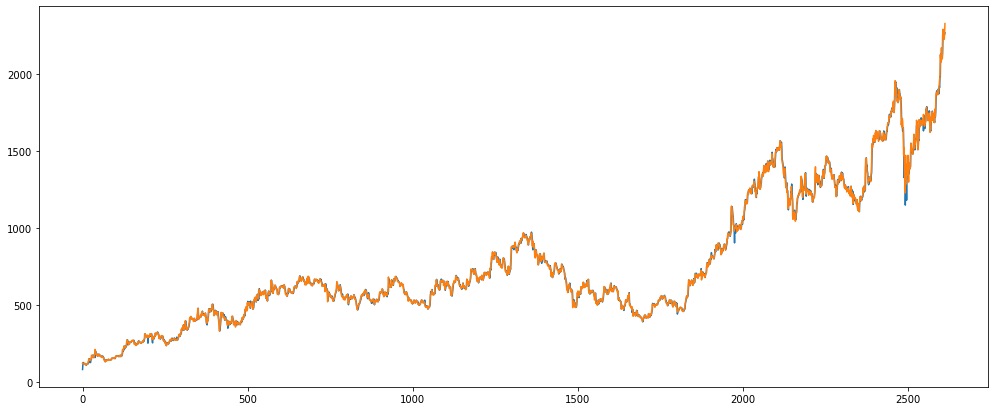

In [ ]:
plt.figure(figsize = [17, 7])
plt.plot(price.Open)
plt.plot(price.Close)
plt.show()

In [ ]:
# Split the Data in Train and Test and Check the Model Performance
tgt = price.Close
x = price.drop(["Date", "Close", "Adj Close", "Volume"], axis = 1)

In [ ]:

xtrain,xtest,ytrain,ytest = train_test_split(x, tgt, test_size = 0.10, random_state = 0)

In [ ]:
# Stacking Models
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, StackingRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor

def base_models():
    models = dict()
    models['lr'] = LinearRegression()
    models["Ridge"] = Ridge()
    models["Lasso"] = Lasso()
    models["Tree"] = DecisionTreeRegressor()
    models["Random Forest"] = RandomForestRegressor()
    models["AdaBoost"] = AdaBoostRegressor()
    models["Bagging"] = BaggingRegressor()
    models["GBM"] = GradientBoostingRegressor()
    return models

In [ ]:
# Now we will apply K Fold Cross Validation. We will now create a evaluate function with Repeated Stratified K Fold
# And Capture the Cross Val Score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, StratifiedKFold, KFold, RepeatedKFold

# Function to evaluate the list of models
def eval_models(model):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = -cross_val_score(model, x, tgt, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [ ]:
# get the models to evaluate
models = base_models()
# evaluate the models and store results
results, names = list(), list() 

for name, model in models.items():
  scores = eval_models(model)
  results.append(scores)
  names.append(name)
  print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

>lr 5.194 (0.423)
>Ridge 5.194 (0.423)
>Lasso 7.502 (0.529)
>Tree 8.008 (0.648)
>Random Forest 6.508 (0.512)
>AdaBoost 20.650 (1.304)
>Bagging 6.764 (0.582)
>GBM 7.976 (0.539)


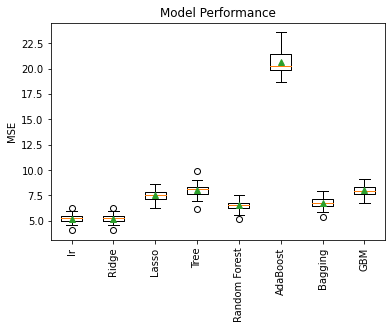

In [ ]:
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.xticks(rotation = 90)
plt.ylabel("MSE")
plt.title("Model Performance")
plt.show()

In [ ]:
# get a stacking ensemble of models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
def get_stacking():
	# define the base models
  level0 = list()
  level0.append(('Tree', DecisionTreeRegressor()))
  level0.append(('RF', RandomForestRegressor()))
  level0.append(('XGB', XGBRegressor()))
  level0.append(('Bagging', BaggingRegressor()))
	# define meta learner model
  level1 = LGBMRegressor()
	# define the stacking ensemble
  model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
  return model

In [ ]:
def base_models():
  models = dict()
  models["Tree"] = DecisionTreeRegressor()
  models["Random Forest"] = RandomForestRegressor()
  models["Bagging"] = BaggingRegressor()
  models["XGB"] = XGBRegressor()
  models["Stacked Model"] = get_stacking()
  return models

>Tree 7.981 (0.679)
>Random Forest 6.494 (0.535)
>Bagging 6.687 (0.585)
>XGB 8.154 (0.600)
>Stacked Model 28.116 (3.094)


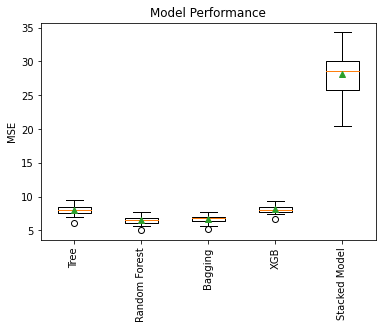

In [ ]:
# Function to evaluate the list of models
def eval_models(model):
  cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = -cross_val_score(model, x, tgt, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
  return scores


# get the models to evaluate
models = base_models()
# evaluate the models and store results
results, names = list(), list() 

for name, model in models.items():
  scores = eval_models(model)
  results.append(scores)
  names.append(name)
  print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))


# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.xticks(rotation = 90)
plt.ylabel("MSE")
plt.title("Model Performance")
plt.show()


In [ ]:
# Lets apply on Train and Test Split
level0 = list()
level0.append(('Tree', DecisionTreeRegressor()))
level0.append(('RF', RandomForestRegressor()))
level0.append(('GBM', GradientBoostingRegressor()))
level0.append(('Bagging', BaggingRegressor()))
level0.append(("XGB", XGBRegressor()))

In [ ]:
level1 = LGBMRegressor()
model = StackingRegressor(estimators=level0, final_estimator=level1, cv=10)

In [ ]:
# Making Predictions on Train & Test
stacked_pred = model.fit(xtrain, ytrain).predict(xtest)

[06:49:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:49:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:49:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:49:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:49:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:49:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:49:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:49:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tools.eval_measures import rmse
# Checking Model Metrics
print(r2_score(ytest, stacked_pred))
print(np.sqrt(mean_squared_error(ytest, stacked_pred)))

0.9991996811128692
12.137576072283768


In [ ]:
xgb = XGBRegressor()

In [ ]:
stacked_pred = xgb.fit(xtrain, ytrain).predict(xtest)

[06:53:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
print(r2_score(ytest, stacked_pred))
print(np.sqrt(mean_squared_error(ytest, stacked_pred)))

0.9989655321612422
13.799359479679797


In [ ]:
lgbm=LGBMRegressor()

In [ ]:
stacked_pred = lgbm.fit(xtrain, ytrain).predict(xtest)
print(r2_score(ytest, stacked_pred))
print(np.sqrt(mean_squared_error(ytest, stacked_pred)))

0.9993517824583638
10.923475061500046


In [ ]:
rf = RandomForestRegressor()
stacked_pred = rf.fit(xtrain, ytrain).predict(xtest)
print(r2_score(ytest, stacked_pred))
print(np.sqrt(mean_squared_error(ytest, stacked_pred)))

0.999442300644988
10.132124156880547


In [ ]:
price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,08/02/10,80.000000,120.449997,80.000000,120.300003,118.110657,113926600
1,09/02/10,115.275002,125.000000,110.800003,122.099998,119.877899,49861112
2,10/02/10,126.000000,126.199997,115.800003,117.500000,115.361618,22791756
3,11/02/10,117.500000,120.000000,112.550003,115.474998,113.373466,11715914
4,15/02/10,116.800003,118.400002,112.750000,114.574997,112.489853,6380560


In [ ]:
# DLF
dlf = pd.read_csv("/gdrive/My Drive/Colab Notebooks/DLF.csv")

In [ ]:
dlf.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,05/07/07,526.599976,583.950012,526.599976,569.799988,500.565369,78025942
1,06/07/07,568.000000,586.450012,568.000000,573.599976,503.903503,13724278
2,09/07/07,574.099976,581.000000,571.500000,574.700012,504.870117,4829804
3,10/07/07,575.000000,580.000000,568.599976,571.750000,502.278412,5321889
4,11/07/07,570.000000,594.400024,567.000000,590.750000,518.969910,8859610


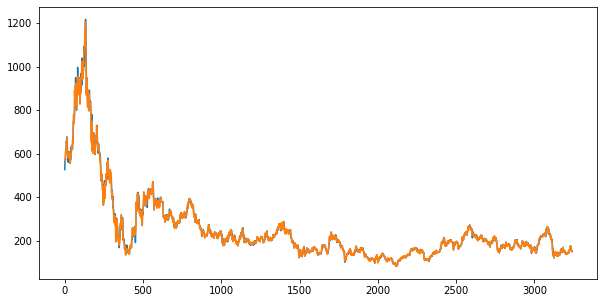

In [ ]:
plt.figure(figsize=[10, 5])
plt.plot(dlf.Open)
plt.plot(dlf.Close)
plt.show()

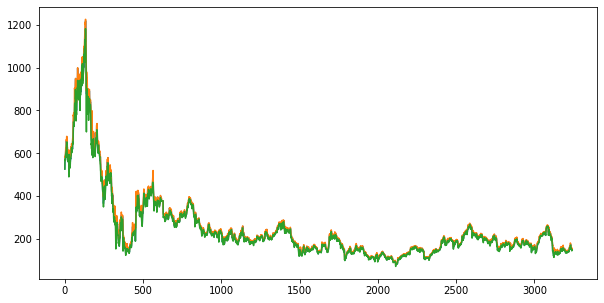

In [ ]:
plt.figure(figsize=[10, 5])
plt.plot(dlf.Open)
plt.plot(dlf.High)
plt.plot(dlf.Low)
plt.show()

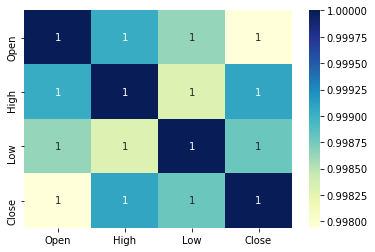

In [ ]:
sns.heatmap(dlf.loc[:, ["Open", "High", "Low", "Close"]].corr(), annot = True, cmap = "YlGnBu")

In [ ]:
dlf.shape

(3242, 7)

In [ ]:
dlf.Close.describe()

count    3242.000000
mean      250.064374
std       169.890604
min        80.800003
25%       155.899994
50%       199.125000
75%       259.337502
max      1208.150024
Name: Close, dtype: float64

In [ ]:
x = dlf.drop(["Date", "Close", "Adj Close", "Volume"], axis = 1)
tgt= dlf.Close

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(x, tgt, test_size = 0.10, random_state = 0)

In [ ]:
rf1 = RandomForestRegressor()

In [ ]:
pred = rf1.fit(xtrain,ytrain).predict(xtest) # training & testing

In [ ]:
print("R2Score: ", r2_score(ytest, pred))
print("RMSE: ", rmse(ytest, pred))

R2Score:  0.9990511607057045
RMSE:  4.7843856327981005


In [ ]:
names = ["Open", "High", "Low"]
price = [156, 158.35, 154.40]

test = pd.DataFrame(data = [price], columns = names)

In [ ]:
# Predicting the CLose Price for DLF
rf1.predict(test)

array([156.13149994])

In [ ]:
trial = pd.read_csv("/gdrive/My Drive/Colab Notebooks/trial2.csv")

In [ ]:
trial

,Open,High,Low,Close
0,149.90,156.90,149.15,154.30
1,151.20,153.25,147.50,150.20
2,149.00,151.35,145.05,150.10
3,152.75,153.90,149.25,150.25
4,139.00,141.00,136.60,138.60
5,125.85,134.20,123.80,126.15


In [ ]:
# Predicted
rf1.predict(trial.drop("Close",axis = 1))

array([154.47900234, 149.89749835, 149.04600396, 151.30050138,
       138.80900444, 127.45750165])

In [ ]:
# xgb.predict(trial.drop("Close",axis = 1))

In [ ]:
#nifty = pd.read_csv("/gdrive/My Drive/Colab Notebooks/Bank Nifty.csv")
sbi = pd.read_csv("/gdrive/My Drive/Colab Notebooks/SBIndia.csv")

In [ ]:
nifty.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2899,07/09/20,23036.25000,23109.09961,22716.25000,22945.05078,22945.05078,245300
2900,08/09/20,22971.19922,23064.15039,22641.40039,22744.40039,22744.40039,0
2901,09/09/20,22486.69922,22554.59961,22080.40039,22267.00000,22267.00000,0
2902,10/09/20,22466.55078,22678.65039,22225.25000,22466.19922,22466.19922,0
2903,11/09/20,22509.94922,22668.75000,22205.94922,22479.94922,22479.94922,0


In [ ]:
# Split the Data in Train and Test
x = nifty.drop(["Date", "Close", "Adj Close", "Volume"], axis = 1)
tgt= nifty.Close

xtrain, xtest, ytrain, ytest = train_test_split(x, tgt, test_size = 0.10, random_state = 0)

rfn = RandomForestRegressor()
pred = rfn.fit(xtrain,ytrain).predict(xtest) # training & testing
print("R2Score: ", r2_score(ytest, pred))
print("RMSE: ", rmse(ytest, pred))

R2Score:  0.9997724993936693
RMSE:  119.30145593141356


In [ ]:
# Predicting the Test Set
names = ["Open", "High", "Low"]
price = [22683.35, 22757.30, 22370.55]

test = pd.DataFrame(data = [price], columns = names)
rfn.predict(test) # Close Price

array([22660.7649025])

In [ ]:
z_nifty = (22330 - nifty.High.mean())/nifty.High.std()
print(z_nifty)
print("The Prob is: ", 1 - stats.norm.cdf(z_nifty))

0.8509175756700955
The Prob is:  0.19740757043484758


In [ ]:
# Preview of SBI

# Tick by Tick Data 
# Candlestick Data
# Volumes, Price, High & Low 
# Is Volume Live - yes, it is available...on an hourly basis
# Deviation from Moving Avg - 2x of Moving Avg (40 Hours)
# 

sbi.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
6096,07/09/20,207.500000,209.649994,205.399994,207.899994,207.899994,35687359
6097,08/09/20,207.899994,208.500000,202.899994,204.050003,204.050003,34146789
6098,09/09/20,201.100006,201.399994,192.500000,194.850006,194.850006,72715826
6099,10/09/20,197.699997,201.449997,195.199997,198.149994,198.149994,67789617
6100,11/09/20,198.550003,203.850006,197.000000,202.699997,202.699997,48487971


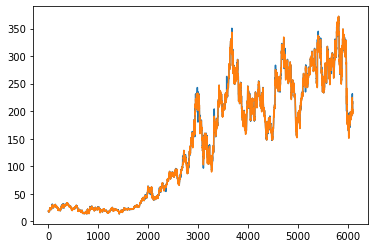

In [ ]:
plt.plot(sbi.Open)
plt.plot(sbi.Close)

In [ ]:
# Split the Data in Train and Test
from sklearn.model_selection import train_test_split
x = sbi.drop(["Date", "Close", "Adj Close", "Volume"], axis = 1)
tgt= sbi.Close

xtrain, xtest, ytrain, ytest = train_test_split(x, tgt, test_size = 0.10, random_state = 0)

In [ ]:
rfsbi = RandomForestRegressor()
pred = rfsbi.fit(xtrain,ytrain).predict(xtest) # training & testing
print("R2Score: ", r2_score(ytest, pred))
print("RMSE: ", rmse(ytest, pred))

# S.Rate is > 60% & Avg Win is 2*Avg Loss : Metric of ML.


R2Score:  0.9997411121305015
RMSE:  1.669874171061494


In [ ]:
# Predicting the Test Set
names = ["Open", "High", "Low"]
price = [199.85, 200.05, 192]

test = pd.DataFrame(data = [price], columns = names)
rfsbi.predict(test) # Close Price: 199 | 198.65

array([194.92651132])

In [ ]:
sbi.Close.describe()

count    6101.000000
mean      141.256497
std       105.745924
min        13.346100
25%        26.692200
50%       143.962006
75%       236.639999
max       372.399994
Name: Close, dtype: float64

In [ ]:
# Covariance between Nifty CLose and SBI Close
np.cov(nifty.tail(2900)["Close"], sbi.tail(2900)["Close"])

array([[6.05619123e+07, 2.19399931e+05],
       [2.19399931e+05, 2.90725458e+03]])

In [ ]:
# Prob of SBI Price going above 206.20
zsc_sbi = (206.20 - sbi.Close.mean())/sbi.Close.std()
print(zsc_sbi)
print("The Prob is: ", 1 - stats.norm.cdf(zsc_sbi))

0.6141466264361388
The Prob is:  0.2695592196965809


In [ ]:
zsc_sbi1 = (206.20 - sbi.High.mean())/sbi.High.std()
print("The Prob is: ", stats.norm.cdf(zsc_sbi1) - stats.norm.cdf(zsc_sbi))

The Prob is:  0.1480995391628125


In [ ]:
# Low 
zsc_sbi = (200 - sbi.Low.mean())/sbi.Low.std()
print(zsc_sbi)
print("The Prob is: ", 1 - stats.norm.cdf(zsc_sbi))

0.5823334944015618
The Prob is:  0.2801710343037056


In [ ]:
daawat = pd.read_csv("/gdrive/My Drive/Colab Notebooks/Daawat.csv")

In [ ]:
daawat.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2006-12-19,5.300,5.785,5.015,5.390,0.599912,63443000.0
1,2006-12-20,5.365,5.530,5.175,5.205,0.579321,12663000.0
2,2006-12-21,5.225,5.255,5.000,5.030,0.559844,5408000.0
3,2006-12-22,5.075,5.090,4.830,4.885,0.543705,3637000.0
4,2006-12-26,4.800,4.955,4.590,4.645,0.516993,5168000.0


In [ ]:
daawat = daawat.dropna()

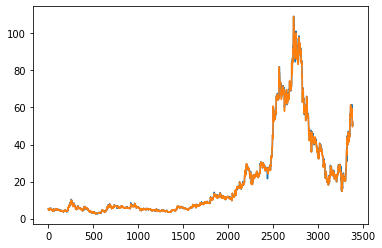

In [ ]:
plt.plot(daawat.Open)
plt.plot(daawat.Close)

In [ ]:
# Train & test
from sklearn.model_selection import train_test_split
newx = daawat.drop(["Date", "Close", "Adj Close", "Volume"], axis = 1)
tgt= daawat.Close

xtrain, xtest, ytrain, ytest = train_test_split(newx, tgt, test_size = 0.10, random_state = 0)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfdaawat = RandomForestRegressor()
pred = rfdaawat.fit(xtrain,ytrain).predict(xtest)

In [ ]:
from sklearn.metrics import r2_score
from statsmodels.tools.eval_measures import rmse
print("R2Score: ", r2_score(ytest, pred))
print("RMSE: ", rmse(ytest, pred))

R2Score:  0.9997176772734467
RMSE:  0.4000622027333959


In [ ]:
trial = pd.read_csv("/gdrive/My Drive/Colab Notebooks/trial3.csv")

In [ ]:
trial

,Open,High,Low,Close
0,56.20,57.80,54.00,57.20
1,56.70,56.80,55.70,56.25
2,35.95,37.00,34.25,34.70
3,21.00,21.45,20.70,21.05
4,28.50,29.10,28.35,28.55


In [ ]:
# Predicted
rf2.predict(trial.drop("Close",axis = 1))

array([56.99050064, 55.65100018, 34.89025112, 21.09249935, 28.53004942])

In [ ]:
names = ["Open", "High", "Low"]
price = [53.55, 55.20, 53.30]

test = pd.DataFrame(data = [price], columns = names)
rfdaawat.predict(test) # Close Price: 52.37

array([53.73549964])

In [ ]:
print("Mean: ", daawat.High.mean())
print("SD: ", daawat.High.std())

Mean:  20.581711727137765
SD:  22.97103317749702


In [ ]:
# What is the probability that price would be in range of 53 to 55
zscore1 = (51.28 - daawat.High.mean())/daawat.High.std()
zscore2 = (54.70 - daawat.High.mean())/daawat.High.std()

In [ ]:
100*(1-stats.norm.cdf(zscore2))

6.8735570874213

In [ ]:
1-  stats.norm.cdf(zscore2) # This shows the probability of z score = 1.49

0.07654791038301256

In [ ]:
(stats.norm.cdf(zscore2) - stats.norm.cdf(zscore1))

0.014162798240189622

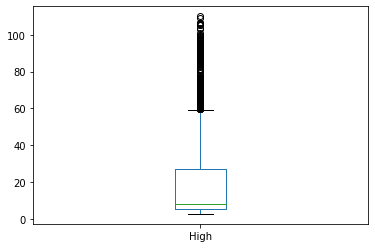

In [ ]:
daawat.High.plot(kind = "box")

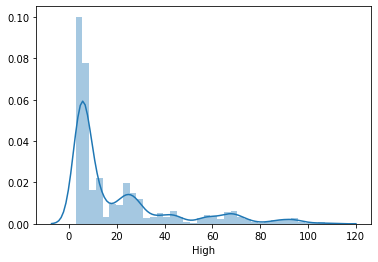

In [ ]:
sns.distplot(daawat.High)

In [ ]:
pip install nsetools

In [ ]:
import nsetools as nse

In [ ]:
import requests
from bs4 import BeautifulSoup

In [ ]:
stockcode = "DAAWAT"
print(stockcode)

DAAWAT


In [ ]:
https://in.finance.yahoo.com/quote/DAAWAT.NS?p=DAAWAT.NS

In [ ]:
stock_url  = 'https://in.finance.yahoo.com/quote/'+stockcode+'.NS?p='+stockcode+'.NS'
print(stock_url)
#headers = {'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.117 Safari/537.36'}
response = requests.get(stock_url)
print(response)

https://in.finance.yahoo.com/quote/DAAWAT.NS?p=DAAWAT.NS
<Response [200]>


In [ ]:
soup = BeautifulSoup(response.text, 'html.parser')

In [ ]:
# Search Span - Data Lies in span
float(soup.find_all("span", {"class":"Trsdu(0.3s) Fw(b) Fz(36px) Mb(-4px) D(ib)"})[0].text)

54.75

In [ ]:
import time
time.time()

1600243223.8517792

In [ ]:
# Web Scraping to Pull the Stock Price of Daawat.

import requests
from bs4 import BeautifulSoup
import time

stockcode = "GLOBUSSPR"
print(stockcode)

stock_url  = 'https://in.finance.yahoo.com/quote/'+stockcode+'.NS?p='+stockcode+'.NS'
print(stock_url)
#headers = {'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.117 Safari/537.36'}
response = requests.get(stock_url)
#print(response)

soup = BeautifulSoup(response.text, 'html.parser')


start_time = time.time()
seconds = 30

while True:
    current_time = time.time()
    elapsed_time = current_time - start_time

    if elapsed_time > seconds:
        stock_url  = 'https://in.finance.yahoo.com/quote/'+stockcode+'.NS?p='+stockcode+'.NS'
        response = requests.get(stock_url)
        soup = BeautifulSoup(response.text, 'html.parser')
        print(soup.find_all("span", {"class":"Trsdu(0.3s) Fw(b) Fz(36px) Mb(-4px) D(ib)"})[0].text)
        break


GLOBUSSPR
https://in.finance.yahoo.com/quote/GLOBUSSPR.NS?p=GLOBUSSPR.NS
280.15
